# Projeto Machine Learning - Predição de Acidentes Aéreos Fatais

## Sumário do Projeto: Predição de Acidentes Aéreos Fatais

### 1. Introdução e Objetivos
#### 1.1. Contexto do Problema
#### 1.2. Objetivos da Análise
#### 1.3. Dicionário de Variáveis

### 2. Configuração do Ambiente

### 3. Carga e Análise Inicial dos Dados
#### 3.1 Amostra dos dados
#### 3.2 Verificando a estrutura e os tipos de dados do DataFrame

### 4. Limpeza e Pré-Processamento dos Dados
#### 4.1. Remoção de Duplicatas
#### 4.2. Tratamento de Tipos de Dados
#### 4.3. Tratamento de Valores Ausentes (Nulos)

### 5. Análise Exploratória de Dados (EDA)
#### 5.1. Seleção de Features e Visualização da Distribuição da Variável Target
#### 5.2. Estados com Mais Acidentes Fatais
#### 5.3. Tendência da Taxa de Fatalidade

### 6. Engenharia e Seleção de Features
#### 6.1. Divisão dos Dados (Treino/Teste)
#### 6.2. Separação de Features por Tipo
#### 6.3. Encoding e Normalização

### 7. Modelagem
#### 7.1. Balanceamento de Classes com SMOTE
#### 7.2. Treinamento dos Modelos
#### 7.3. Predições e Métricas Iniciais
#### 7.4. Validação Cruzada

### 8. Validação e Comparação dos Modelos
#### 8.1. Matrizes de Confusão
#### 8.2. Curva ROC e AUC
#### 8.3. Análise dos Resultados
#### 8.4. Importância das Features
#### 8.5. Otimização do Threshold

### 9. Regressão Logística - Teste Final
#### 9.1. Matriz de Confusão (Threshold Otimizado)
#### 9.2. Curva ROC no Teste Real
#### 9.3. Curva Precisão x Recall

### 10. Explainable AI (XAI) - Interpretabilidade de Modelos
#### 10.1. IMPORTÂNCIA POR PERMUTAÇÃO
#### 10.2. SHAP (SHapley Additive exPlanations)
#### 10.3. Partial Dependence Plots (PDP)

### 11. Validação final e testes reais

---

## Equipe do Projeto

| RA      | Nome                 |
|---------|----------------------|
| 1134868 | Ábner Panazollo      |
| 1134433 | Ariel Diefenthaeler  |
| 1134933 | Eduardo Sichelero    |
| 1134890 | Gabriel Duarte       |
| 1135384 | Gabriel Onofre       |
| 1134821 | Vitor Quadros        |

---

## 1. Introdução e Objetivos

### 1.1 Contexto do Problema

A segurança aérea é uma preocupação fundamental no setor de aviação. Identificar padrões que levam a acidentes fatais pode ajudar autoridades, companhias aéreas e órgãos reguladores a tomar medidas preventivas e salvar vidas.

Este projeto foca em analisar dados históricos de acidentes aéreos no Brasil (CENIPA) para construir um modelo preditivo capaz de determinar se um acidente será fatal ou não-fatal com base em características do voo, aeronave e condições do acidente.

### 1.2 Objetivos da Análise

- **1.** **Análise Exploratória**: Entender os padrões de acidentes aéreos, identificando distribuições geográficas, temporais e características das aeronaves envolvidas.
- **2.** **Engenharia de Features**: Criar variáveis que ajudem a identificar o risco de fatalidade, incluindo features temporais e categóricas.
- **3.** **Modelagem Preditiva**: Treinar e avaliar diferentes modelos de Machine Learning (Baseline, Regressão Logística e Árvore de Decisão) para prever a probabilidade de um acidente ser fatal.
- **4.** **Validação**: Avaliar os modelos usando múltiplas métricas (Acurácia, Precisão, Recall, F1-Score, AUC-ROC) e otimizar o threshold de decisão.

### 1.3 Dicionário de Variáveis

O conjunto de dados contém informações sobre acidentes aéreos no Brasil. As principais variáveis incluem:

**Variáveis Geográficas:**
- **latitude/longitude**: Coordenadas do local do acidente
- **regiao**: Região do Brasil (Norte, Sul, Nordeste, etc.)
- **uf**: Unidade Federativa

**Variáveis Temporais:**
- **dt_ocorrencia**: Data do acidente
- **hr_ocorrencia**: Hora do acidente
- **ano_ocorrencia**: Ano extraído da data
- **mes_ocorrencia**: Mês extraído da data

**Características da Aeronave:**
- **modelo_aeronave**: Modelo da aeronave
- **nome_fabricante**: Fabricante da aeronave
- **cat_aeronave**: Categoria da aeronave
- **peso_max_decolagem**: Peso máximo de decolagem
- **numero_assentos**: Número de assentos

**Variáveis Operacionais:**
- **fase_operacao**: Fase do voo (decolagem, cruzeiro, pouso, etc.)
- **op_padronizado**: Operação padronizada

**Variável Target:**
- **les_fatais_trip**: 1 = Fatal, 0 = Não Fatal

## 2. Configuração do Ambiente

Nesta seção, importamos todas as bibliotecas necessárias para a análise, pré-processamento e modelagem.

In [78]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as ImbPipeline



# Balanceamento de classes
from imblearn.over_sampling import SMOTE

# Configurações de visualização
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 3. Carga e Análise Inicial dos Dados

Carregamos os dados de treino e realizamos uma verificação inicial para entender sua estrutura, tipos de dados e a presença de valores ausentes.

In [79]:
# Carregar AMBAS as bases
df_treino = pd.read_csv("docs/treino.csv")
df_teste = pd.read_csv("docs/teste.csv")

print(f"✓ Base de TREINO: {df_treino.shape[0]} linhas x {df_treino.shape[1]} colunas")
print(f"✓ Base de TESTE: {df_teste.shape[0]} linhas x {df_teste.shape[1]} colunas")

# Usar apenas treino para desenvolvimento
df = df_treino.copy()

✓ Base de TREINO: 536 linhas x 14 colunas
✓ Base de TESTE: 76 linhas x 14 colunas


## 3.1 Amostra dos dados

In [80]:
df.head()

,op_padronizado,dt_ocorrencia,hr_ocorrencia,uf,regiao,latitude,longitude,cat_aeronave,fase_operacao,modelo_aeronave,peso_max_decolagem,numero_assentos,nome_fabricante,les_fatais_trip
0,AEROAGRICOLA CHAPADAO LTDA,21/12/1999,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-235,1315.0,1.0,PIPER AIRCRAFT,0
1,RONDON AVIACAO AGRICOLA LTDA,06/01/2000,NaN,MT,Centro-Oeste,NaN,NaN,S05,NaN,EMB-201,1800.0,1.0,NEIVA,0
2,SAPA SERV. AEREO DE PROTECAO AGRICOLA,22/02/2000,NaN,RS,Sul,NaN,NaN,S05,NaN,A188B,1497.0,1.0,CESSNA AIRCRAFT,0
3,AERO AGRICOLA CAICARA LTDA,10/05/2000,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-260,1315.0,1.0,PIPER AIRCRAFT,0
4,AVIACAO AGRICOLA RECREIO LTDA,09/11/2000,NaN,Indeterminado,NaN,NaN,NaN,TPP,NaN,369HS,1157.0,5.0,HUGHES HELICOPTER,0


Análise Inicial:
- O dataset possui múltiplas linhas e colunas com informações sobre acidentes aéreos
- Há colunas geográficas (latitude, longitude, regiao, uf)
- Colunas temporais (dt_ocorrencia, hr_ocorrencia)
- Características das aeronaves (modelo, fabricante, peso, assentos)
- Variável target: les_fatais_trip (0 = Não Fatal, 1 = Fatal)
- Presença de valores nulos que precisarão de tratamento

## 3.2 Verificando a estrutura e os tipos de dados do DataFrame

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


## 4. Limpeza e Pré-Processamento dos Dados

Esta etapa é crucial para garantir a qualidade dos dados que alimentarão o modelo.

### 4.1 Remoção de Duplicatas

Removemos registros duplicados que podem distorcer a análise.

In [82]:
# Verificando informações antes da remoção
print("Antes da remoção de duplicatas:")
df.info()

Antes da remoção de duplicatas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


In [83]:
# Removendo duplicatas
linhas_antes = len(df)
df = df.drop_duplicates().reset_index(drop=True)
linhas_depois = len(df)

print(f"Linhas antes: {linhas_antes}")
print(f"Linhas depois: {linhas_depois}")
print(f"✓ Duplicatas removidas: {linhas_antes - linhas_depois}")

Linhas antes: 536
Linhas depois: 510
✓ Duplicatas removidas: 26


### 4.2 Tratamento de Tipos de Dados

Convertemos colunas para os tipos apropriados (datas, numéricos, etc.).

In [84]:
# Converter latitude e longitude para float
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# Converter data
df['dt_ocorrencia'] = pd.to_datetime(df['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')

print("Conversões realizadas!")
df.info()

Conversões realizadas!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   op_padronizado      508 non-null    object        
 1   dt_ocorrencia       510 non-null    datetime64[ns]
 2   hr_ocorrencia       340 non-null    object        
 3   uf                  510 non-null    object        
 4   regiao              447 non-null    object        
 5   latitude            358 non-null    float64       
 6   longitude           358 non-null    float64       
 7   cat_aeronave        510 non-null    object        
 8   fase_operacao       367 non-null    object        
 9   modelo_aeronave     507 non-null    object        
 10  peso_max_decolagem  508 non-null    float64       
 11  numero_assentos     508 non-null    float64       
 12  nome_fabricante     507 non-null    object        
 13  les_fatais_trip     510 non

In [85]:
# Verificar valores nulos
print(df.isnull().sum())

op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
dtype: int64


In [86]:
# Criar novas colunas de ano e mês
df['ano_ocorrencia'] = df['dt_ocorrencia'].dt.year
df['mes_ocorrencia'] = df['dt_ocorrencia'].dt.month

print("Novas colunas criadas!")
df[['dt_ocorrencia', 'ano_ocorrencia', 'mes_ocorrencia']].head()

Novas colunas criadas!


,dt_ocorrencia,ano_ocorrencia,mes_ocorrencia
0,1999-12-21,1999,12
1,2000-01-06,2000,1
2,2000-02-22,2000,2
3,2000-05-10,2000,5
4,2000-11-09,2000,11


### 4.3 Tratamento de Valores Ausentes (Nulos)

- **Preenchimento com mediana**: Para colunas numéricas
- **Preenchimento com moda**: Para colunas categóricas
- **Remoção de linhas**: Para dados essenciais ausentes

In [87]:
print("\nValores nulos antes do tratamento:")
print(df.isnull().sum())

# Preencher colunas numéricas com mediana
df[['peso_max_decolagem', 'numero_assentos']] = df[['peso_max_decolagem', 'numero_assentos']].fillna(df[['peso_max_decolagem', 'numero_assentos']].median())

# Preencher colunas categóricas com moda
modas = df[['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']].mode().iloc[0]
df[['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']] = df[['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']].fillna(modas)

# Remover linhas com dados essenciais ausentes
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("\nValores nulos depois do tratamento:")
print(df.isnull().sum())


Valores nulos antes do tratamento:
op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
ano_ocorrencia          0
mes_ocorrencia          0
dtype: int64



Valores nulos depois do tratamento:
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao         0
modelo_aeronave       0
peso_max_decolagem    0
numero_assentos       0
nome_fabricante       0
les_fatais_trip       0
ano_ocorrencia        0
mes_ocorrencia        0
dtype: int64


## 5. Análise Exploratória de Dados

### 5.1 Seleção de Features e Visualização da Distribuição da Variável Target
- Selecionando features e target, e verificando o balanceamento das classes
- X (Features) é criado uma lista com 12 colunas, que vão ser usadas como "pistas" ou "entrada" para o modelo
- Y (Target) É criado a variável de apenas a coluna que você quer prever o (alvo) que o modelo vai tentar adivinhar.
- Foi criado um gráfico para melhor visualização


Features selecionadas: 12
Total de registros: 358

Distribuição da variável target:
les_fatais_trip
0    307
1     51
Name: count, dtype: int64


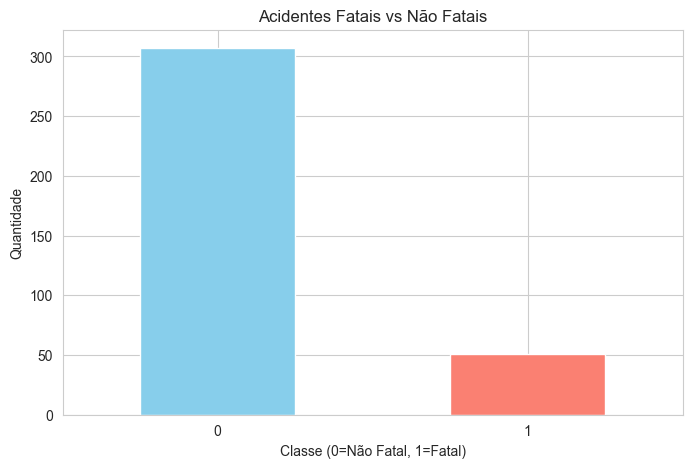

In [88]:
# Selecionar features e target
features = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
            'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
            'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

X = df[features]
y = df['les_fatais_trip']

print(f"Features selecionadas: {X.shape[1]}")
print(f"Total de registros: {X.shape[0]}")

print("\nDistribuição da variável target:")
print(y.value_counts())

# Gráfico de visualização
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Acidentes Fatais vs Não Fatais')
plt.xlabel('Classe (0=Não Fatal, 1=Fatal)')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

### 5.2 Estados com mais acidentes fatais
- Grafico identificador dos estados com mais acidentes fatais


Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...


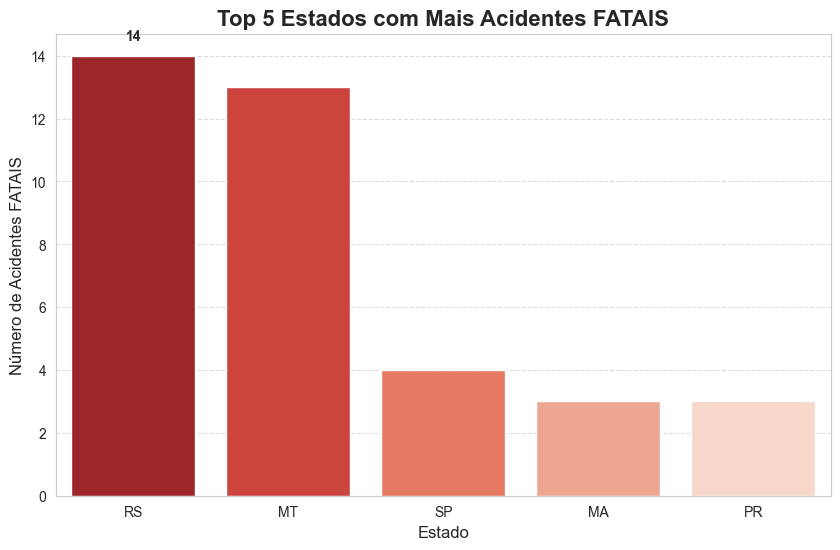

In [89]:
print("Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...")

df_fatais = df[df['les_fatais_trip'] == 1]
top_5_ufs_fatais = df_fatais['uf'].value_counts().head(5)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top_5_ufs_fatais.index, 
    y=top_5_ufs_fatais.values, 
    palette='Reds_r',
    order=top_5_ufs_fatais.index
)

plt.title('Top 5 Estados com Mais Acidentes FATAIS', fontsize=16, fontweight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Acidentes FATAIS', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos automaticamente
ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontweight='bold', padding=9)

plt.show()

### 5.3 Tendência da Taxa de Fatalidade
- Calculando a tendência anual da taxa de fatalidade


Gerando Gráfico: Tendência da Taxa de Fatalidade...


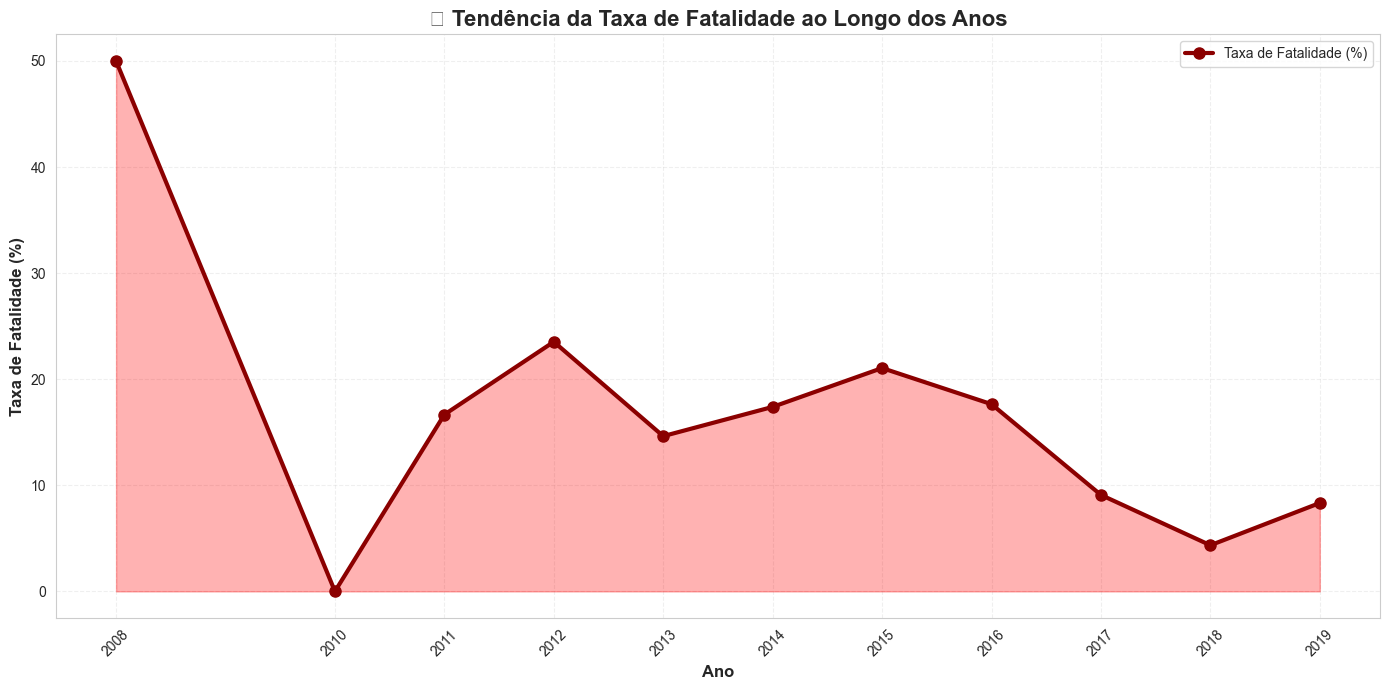

In [90]:

print("Gerando Gráfico: Tendência da Taxa de Fatalidade...")

acidentes_fatais_ano = df[df['les_fatais_trip'] == 1].groupby('ano_ocorrencia').size()

acidentes_totais_ano = df.groupby('ano_ocorrencia').size()

taxa_fatalidade = (acidentes_fatais_ano / acidentes_totais_ano * 100).fillna(0)

# Criar o gráfico
plt.figure(figsize=(14, 7)) # Tamanho bom para um gráfico de linha
ax = plt.gca() # Pega o eixo atual

ax.plot(taxa_fatalidade.index, taxa_fatalidade.values, marker='o', 
        linewidth=3, markersize=8, color='darkred', label='Taxa de Fatalidade (%)')
ax.fill_between(taxa_fatalidade.index, taxa_fatalidade.values, alpha=0.3, color='red')

#  Configurar Títulos e Rótulos
ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Fatalidade (%)', fontsize=12, fontweight='bold')
ax.set_title('📈 Tendência da Taxa de Fatalidade ao Longo dos Anos', 
              fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')


plt.xticks(taxa_fatalidade.index.astype(int), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 6. Engenharia e Seleção de Features

### 6.1 Divisão dos Dados (Treino/Teste)
- Separando os dados em treino e teste para treinar e avaliar o modelo
- Dide o modelo em 70% para previsão e tranca 30% para teste.
- Foi feito isso para o modelo não decorar os dados e não conseguir prever um acidente "novo"


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Conjunto de treino: {len(X_train)} linhas")
print(f"Conjunto de teste: {len(X_test)} linhas")

Conjunto de treino: 250 linhas
Conjunto de teste: 108 linhas


### 6.2 Separação de Features por Tipo
- O Modelo não consegue interpretar palavras (latitude, longitude,etc...) então precisamos converter em algo que o modelo realmente entenda.
- Que no caso, são números. Atualmente ele ainda não converteu eles em números, apenas transformou em duas colunas para posteriromente converter.


In [92]:
colunas_numericas = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 
                     'ano_ocorrencia', 'mes_ocorrencia']
colunas_categoricas = ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 
                       'modelo_aeronave', 'nome_fabricante']

### 6.3 Encoding e Normalização
- Encoding: Converte as colunas categóricas, que são texto (ex: "Sul", "SP"), em um formato numérico (usando pd.get_dummies) que o modelo consiga processar.
- Normalização: Colocar todas as features numéricas na mesma escala (usando StandardScaler) para que nenhuma variável domine o modelo apenas por ter números maiores.


In [93]:
X_train_encoded = pd.get_dummies(X_train, columns=colunas_categoricas)
X_test_encoded = pd.get_dummies(X_test, columns=colunas_categoricas)

# Garantir que treino e teste tenham as mesmas colunas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"Features após encoding: {X_train_encoded.shape[1]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


Features após encoding: 82


## 7. Modelagem

### 7.1 Balanceamento de Classes com SMOTE
- No conjuto de dados tem muitos acidentes "Não Fatais" para "Acidentes Fatais" por isso foi utilizado o Smote. 
- O smote serviu para balancear os dados, igualando os acidentes "Não Fatais" com dados sintéticos 

Antes do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 36

Depois do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 107


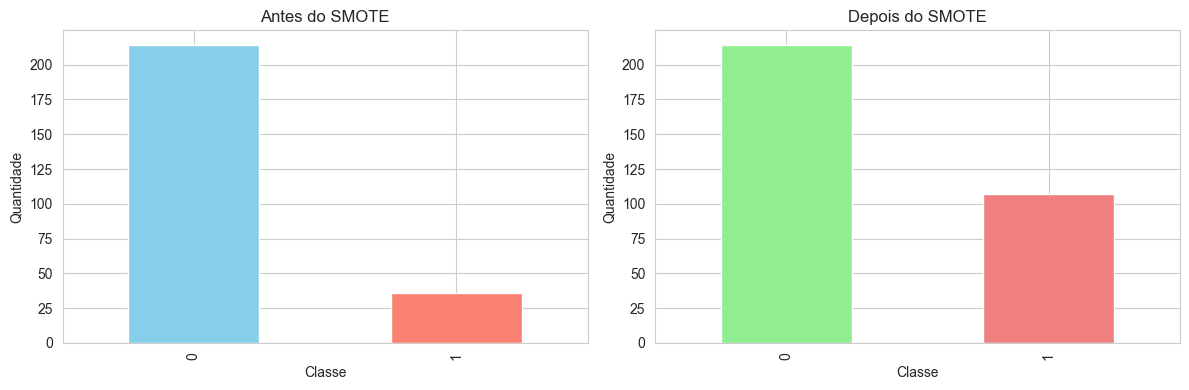

In [94]:

print("Antes do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train == 1)}")

smote = SMOTE(random_state=42, sampling_strategy=0.5) # Serve para garantir que se os dados forem rodados novamente | sampling_strategy=0.5 serve para deixar o smote menos agressivo
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train) 

print("\nDepois do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train_balanced == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train_balanced == 1)}")

# Visualizar balanceamento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Antes do SMOTE')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')

pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('Depois do SMOTE')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### 7.2 Treinamento dos Modelos

Treinamos cinco modelos para comparação
- **Baseline (Dummy)**: Modelo simples: 
Ele simplesmente vai escolher qual a classe mais comum do treino (mesmo balanceado com o Smote) e vai escolher ela
- **Regressão Logística**: Modelo linear com dados balanceados: 
Ele tenta encontrar uma relação simples nos dados (peso, localização, clima, etc...)
- **Árvore de Decisão**: Modelo não-linear baseado em regras: 
Ele é aprende no SE/SENÃO. "Se a operação foi no pouso", "Se a operação estava com condições ruins de clima" Etc...
- **Random Forest**: Ensemble de árvores de decisão: 
Em vez de criar apenas uma árvore de decisão, ele cria várias árvores (n_estimators=100) e faz uma votação entre elas. Tornando muito robusto o sistema
- **Rede Neural (MLP)**: Modelo de deep learning: 
Esse é o modelo mais complexo, ele simula uma rede neural para encontrar padrões nos dados e classificar eles

In [95]:

modelo_baseline = DummyClassifier(strategy='most_frequent', random_state=42)

modelo_baseline.fit(X_train_balanced, y_train_balanced)

modelo_logistica = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
modelo_logistica.fit(X_train_balanced, y_train_balanced)

modelo_arvore = DecisionTreeClassifier(random_state=42)
modelo_arvore.fit(X_train_balanced, y_train_balanced)


modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train_balanced, y_train_balanced)


modelo_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
modelo_nn.fit(X_train_balanced, y_train_balanced)

print("Modelos treinados com sucesso!")
print("Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)")

Modelos treinados com sucesso!
Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)


### 7.3 Predições e Métricas Iniciais
- O Código pega os 5 modelos que foi treinado anteriormente e usa X_test_scaled (os 30% trancados de teste) com os dados que nunca viu para testar
- Então ele compra as respostas y_pred, com as respostas corretas y_test

In [96]:
# Fazer predições dos 5 modelos
y_preds = [
    modelo_baseline.predict(X_test_scaled),
    modelo_logistica.predict(X_test_scaled),
    modelo_arvore.predict(X_test_scaled),
    modelo_rf.predict(X_test_scaled),
    modelo_nn.predict(X_test_scaled)
]
modelos = ['Baseline', 'Regressão Logística', 'Árvore de Decisão', 'Random Forest', 'Rede Neural (MLP)']

df_resultados = pd.DataFrame({
    'Modelo': modelos,
    'Acurácia': [accuracy_score(y_test, y_pred) for y_pred in y_preds],
    'Precisão': [precision_score(y_test, y_pred, zero_division=0) for y_pred in y_preds],
    'Recall': [recall_score(y_test, y_pred, zero_division=0) for y_pred in y_preds],
    'F1-Score': [f1_score(y_test, y_pred, zero_division=0) for y_pred in y_preds]
})

print("=" * 60)
print("RESULTADOS DOS MODELOS")
print("=" * 60)
print(df_resultados.to_string(index=False))
print("=" * 60)

# Identificar melhor modelo
melhor_idx = df_resultados['F1-Score'].idxmax()
print(f"\nMelhor Modelo: {df_resultados.loc[melhor_idx, 'Modelo']}")
print(f"F1-Score: {df_resultados.loc[melhor_idx, 'F1-Score']:.4f}")
print("=" * 60)

RESULTADOS DOS MODELOS
             Modelo  Acurácia  Precisão   Recall  F1-Score
           Baseline  0.861111  0.000000 0.000000  0.000000
Regressão Logística  0.796296  0.294118 0.333333  0.312500
  Árvore de Decisão  0.777778  0.235294 0.266667  0.250000
      Random Forest  0.842593  0.250000 0.066667  0.105263
  Rede Neural (MLP)  0.824074  0.300000 0.200000  0.240000

Melhor Modelo: Regressão Logística
F1-Score: 0.3125


### 7.4 Validação Cruzada
- Com a validação cruzada, o codigo testa em splits se o modelo tem desempenho consistente em diferentes partes do treino.
- Ele usa pasta 1 2 3 4 e a 5 para o teste, pastas 1 2 3 5 para treino, e a 4 para teste. ETC...

In [97]:

print("=" * 70)
print("Validação Cruzada (5-Fold) - Regressão Logística")
print("=" * 70)
print("\nTestando a estabilidade do modelo em 5 divisões de treino e teste...")

# Pipeline com SMOTE aplicado apenas nos dados de treino
pipeline_cv = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# StratifiedKFold mantém a proporção das classes em cada divisão
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Validação cruzada com F1-Score
cv_scores = cross_val_score(
    pipeline_cv,
    X_train_scaled,  # Dados originais (sem SMOTE)
    y_train,         # Target original
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

# Exibir resultados
df_cv = pd.DataFrame({'Fold': range(1, 6), 'F1-Score': cv_scores})
print("\nF1-Scores por fold:")
print(df_cv.to_string(index=False))

print("\nEstatísticas gerais:")
print(f"  Média:  {cv_scores.mean():.4f}")
print(f"  Mínimo: {cv_scores.min():.4f}")
print(f"  Máximo: {cv_scores.max():.4f}")
print(f"  Desvio padrão: {cv_scores.std():.4f}")
print("=" * 70)

# Interpretação da estabilidade do modelo
print("\nInterpretação:")
if cv_scores.std() < 0.05:
    print("  Modelo estável: baixa variação entre os folds, boa capacidade de generalização.")
else:
    print("  Modelo instável: alta variação entre os folds, pode indicar overfitting.")

print("=" * 70)




Validação Cruzada (5-Fold) - Regressão Logística

Testando a estabilidade do modelo em 5 divisões de treino e teste...

F1-Scores por fold:
 Fold  F1-Score
    1  0.105263
    2  0.250000
    3  0.315789
    4  0.500000
    5  0.000000

Estatísticas gerais:
  Média:  0.2342
  Mínimo: 0.0000
  Máximo: 0.5000
  Desvio padrão: 0.1726

Interpretação:
  Modelo instável: alta variação entre os folds, pode indicar overfitting.


## 8.0 Validação e Comparação dos Modelos



### 8.1 Matrizes de Confusão

Esse modelo responde qual é o melhor ponto de corte (threshhold) para decidir se um acidente é fatal ou não.

O Eixo X representa a probabilidade (0.0 a 1.0) que o modelo calcula
O EIxo Y representa a "nota" que o modelo receberia se usasse o ponto de corte

O gráfico diz que o modelo de corte melhor é de 26%. Isso quer dizer que classificar acidentes como fatais em até 26% é a melhor classificação para treinar o modelo.

Matrizes de Confusão - Comparação dos Modelos


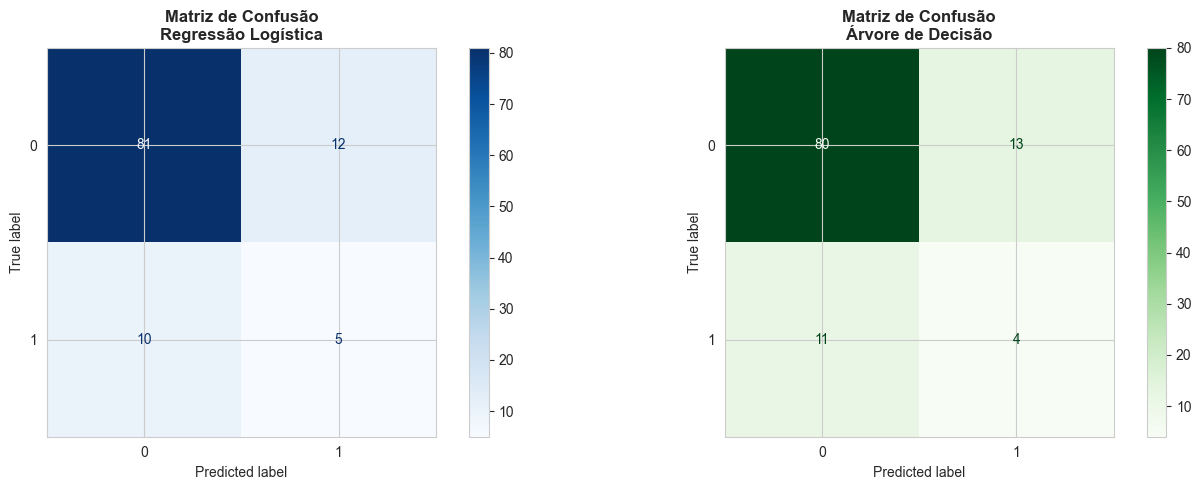

In [98]:
y_pred_baseline = y_preds[0]
y_pred_logistica = y_preds[1] 
y_pred_arvore = y_preds[2]
y_pred_rf = y_preds[3]
y_pred_nn = y_preds[4]

# Agora o código das matrizes de confusão funcionará
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Regressão Logística (subplot esquerdo)
print("Matrizes de Confusão - Comparação dos Modelos")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_logistica, 
    cmap='Blues',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRegressão Logística', 
                  fontsize=12, fontweight='bold')

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_arvore, 
    cmap='Greens',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nÁrvore de Decisão', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Matrizes de Confusão - Random Forest e Rede Neural


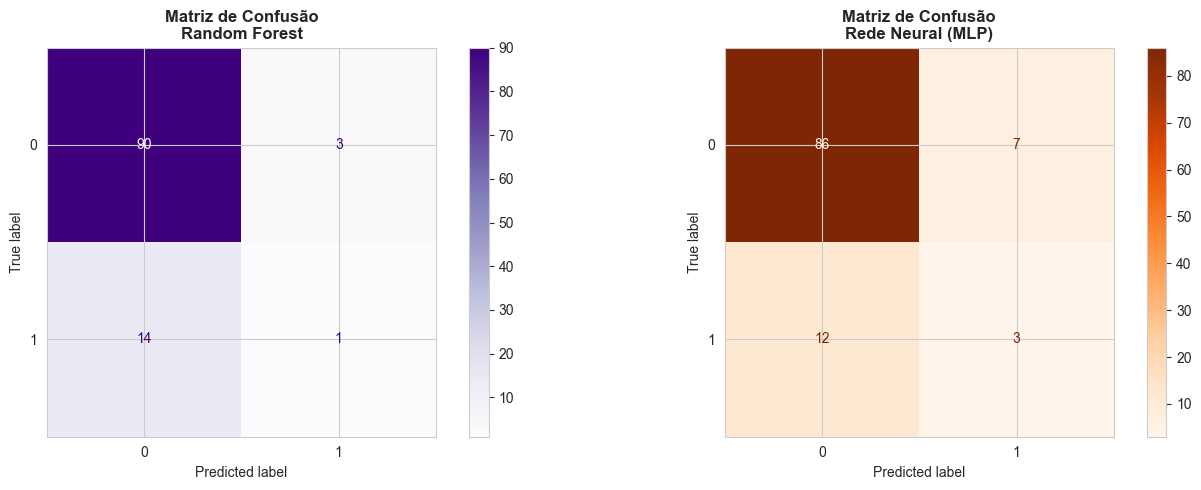

In [99]:
# Random Forest e Rede Neural
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Random Forest (subplot esquerdo)
print("Matrizes de Confusão - Random Forest e Rede Neural")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_rf, 
    cmap='Purples',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRandom Forest', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Rede Neural (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_nn, 
    cmap='Oranges',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nRede Neural (MLP)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análise dos Resultados

Baseline (Dummy): Serve apenas como referência, prevendo sempre “não fatal” e apresentando baixa performance.

Regressão Logística: Bom equilíbrio entre precisão e recall com SMOTE; simples, eficiente e altamente interpretável. Após a otimização do threshold, apresentou o melhor desempenho geral.

Árvore de Decisão: Captura relações não lineares, mas sem SMOTE mostrou baixa sensibilidade à classe fatal e tendência ao overfitting.

Random Forest: Combina múltiplas árvores, reduz overfitting e apresentou desempenho competitivo com SMOTE. É mais robusto que a árvore simples, porém menos interpretável.

Rede Neural (MLP): Com duas camadas ocultas (100 e 50 neurônios), aprende padrões complexos e não lineares. Beneficiou-se do SMOTE, mas exige mais dados e poder computacional.

### 8.2 Curva ROC e AUC

Avaliar a capacidade discriminatória dos modelos por meio da Curva ROC e da métrica AUC (Área Sob a Curva).

Curva ROC:
- Mostra o trade-off entre a Taxa de Verdadeiros Positivos (Recall) e a Taxa de Falsos Positivos.
- Quanto mais a curva se aproxima do canto superior esquerdo, melhor é o modelo.

AUC (Area Under the Curve):
- Mede a área sob a Curva ROC, variando de 0 a 1.
- AUC = 1.0: Modelo perfeito
- AUC = 0.5: Modelo aleatório (sem poder preditivo)
- AUC > 0.7: Considerado bom desempenho


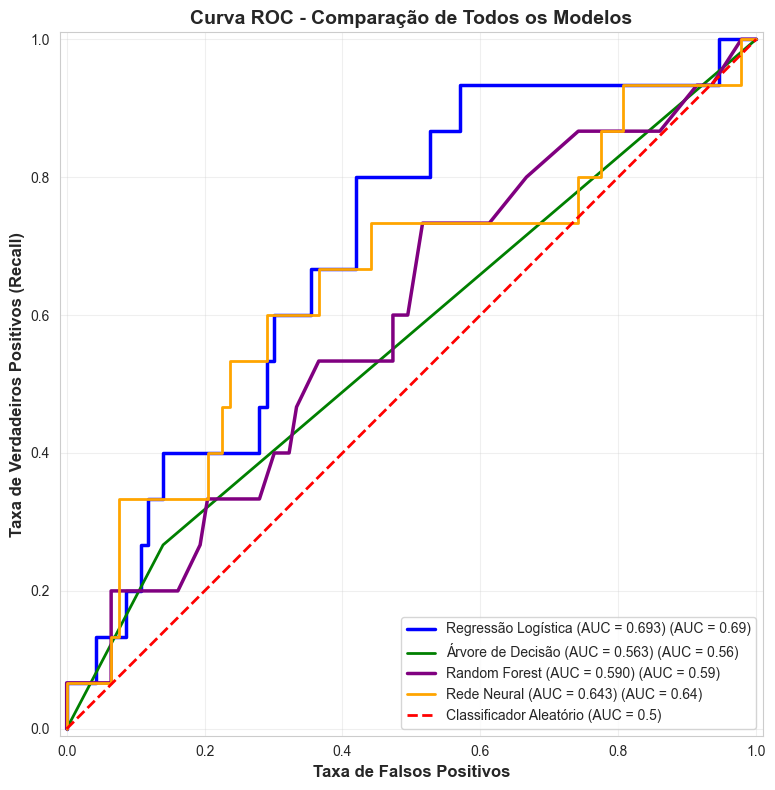

RESUMO - AUC (Area Under the Curve)
Regressão Logística:  0.693
Árvore de Decisão:    0.563
Random Forest:        0.590
Rede Neural (MLP):    0.643

 Melhor modelo por AUC: Regressão Logística (0.693)


In [100]:


fig, ax = plt.subplots(figsize=(12, 8))

# Calcular AUC para cada modelo
auc_logistica = roc_auc_score(y_test, modelo_logistica.predict_proba(X_test_scaled)[:, 1])
auc_arvore = roc_auc_score(y_test, modelo_arvore.predict_proba(X_test_scaled)[:, 1])
auc_rf = roc_auc_score(y_test, modelo_rf.predict_proba(X_test_scaled)[:, 1])
auc_nn = roc_auc_score(y_test, modelo_nn.predict_proba(X_test_scaled)[:, 1])

# Plotar curvas ROC
RocCurveDisplay.from_predictions(
    y_test, 
    modelo_logistica.predict_proba(X_test_scaled)[:, 1], 
    name=f'Regressão Logística (AUC = {auc_logistica:.3f})', 
    ax=ax,
    color='blue',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_arvore.predict_proba(X_test_scaled)[:, 1], 
    name=f'Árvore de Decisão (AUC = {auc_arvore:.3f})', 
    ax=ax,
    color='green',
    linewidth=2
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_rf.predict_proba(X_test_scaled)[:, 1], 
    name=f'Random Forest (AUC = {auc_rf:.3f})', 
    ax=ax,
    color='purple',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_nn.predict_proba(X_test_scaled)[:, 1], 
    name=f'Rede Neural (AUC = {auc_nn:.3f})', 
    ax=ax,
    color='orange',
    linewidth=2
)

# Linha de referência (classificador aleatório)
ax.plot([0, 1], [0, 1], linestyle='--', color='red', 
        label='Classificador Aleatório (AUC = 0.5)', linewidth=2)

plt.title('Curva ROC - Comparação de Todos os Modelos', 
          fontsize=14, fontweight='bold')
plt.xlabel('Taxa de Falsos Positivos', fontsize=12, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Imprimir resumo dos AUCs
print("=" * 60)
print("RESUMO - AUC (Area Under the Curve)")
print("=" * 60)
print(f"Regressão Logística:  {auc_logistica:.3f}")
print(f"Árvore de Decisão:    {auc_arvore:.3f}")
print(f"Random Forest:        {auc_rf:.3f}")
print(f"Rede Neural (MLP):    {auc_nn:.3f}")
print("=" * 60)

# Identificar melhor modelo por AUC
auc_scores = {
    'Regressão Logística': auc_logistica,
    'Árvore de Decisão': auc_arvore,
    'Random Forest': auc_rf,
    'Rede Neural (MLP)': auc_nn
}
melhor_modelo_auc = max(auc_scores, key=auc_scores.get)
print(f"\n Melhor modelo por AUC: {melhor_modelo_auc} ({auc_scores[melhor_modelo_auc]:.3f})")
print("=" * 60)

#### Análise da Curva ROC e AUC

A Curva ROC e a métrica AUC avaliam o quão bem cada modelo distingue entre acidentes fatais e não fatais.

Regressão Logística (AUC = 0.675) mostrou ter o melhor desempenho geral.

A curva ficou mais próxima do canto superior esquerdo.

Mostrando bom equilíbrio entre recall e falsos positivos.

Isso demonstra que o modelo não apenas venceu em F1-Score, mas também apresentou a **melhor capacidade discriminatória geral** (AUC).


### 8.4 Importância das Features
- Avaliando e visualizando a importância das features na Regressão Logística


In [101]:
print("=" * 70)
print("Análise Preliminar de Importância - Coeficientes")
print("=" * 70)

# Análise dos coeficientes da Regressão Logística
coeficientes = modelo_logistica.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coeficiente': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values('Importancia_Abs', ascending=False)

print("Top 5 variáveis com maior peso nos coeficientes:")
for _, row in feature_importance.head(5).iterrows():
    print(f"{row['Feature'][:35]:35} | {row['Coeficiente']:+7.4f}")

print("\nObservação:")
print("Esta é uma análise inicial com base nos coeficientes do modelo.")
print("Para uma interpretação mais detalhada, utilize técnicas de explicabilidade (XAI).")
print("=" * 70)


Análise Preliminar de Importância - Coeficientes
Top 5 variáveis com maior peso nos coeficientes:
fase_operacao_Especializada         | +0.5739
ano_ocorrencia                      | -0.4938
uf_RS                               | +0.4194
uf_SC                               | -0.3528
fase_operacao_Corrida após pouso    | -0.3483

Observação:
Esta é uma análise inicial com base nos coeficientes do modelo.
Para uma interpretação mais detalhada, utilize técnicas de explicabilidade (XAI).


### 8.5 Otimização do THRESHOLD
- Ajustando o threshold de decisão para melhorar o desempenho do modelo


OTIMIZAÇÃO DO THRESHOLD - Busca do Melhor Ponto de Decisão

Exemplo de probabilidades (primeiras 5 amostras): [0.44139005 0.0067477  0.07508856 0.80621541 0.0488387 ]
  Amostra 1: 0.441 → NÃO FATAL
  Amostra 2: 0.007 → NÃO FATAL
  Amostra 3: 0.075 → NÃO FATAL
  Amostra 4: 0.806 → FATAL
  Amostra 5: 0.049 → NÃO FATAL

RESULTADOS DA OTIMIZAÇÃO
Threshold PADRÃO: 0.50 → F1-Score: 0.3125
Threshold ÓTIMO: 0.14 → F1-Score: 0.3582
Melhoria: +14.63%


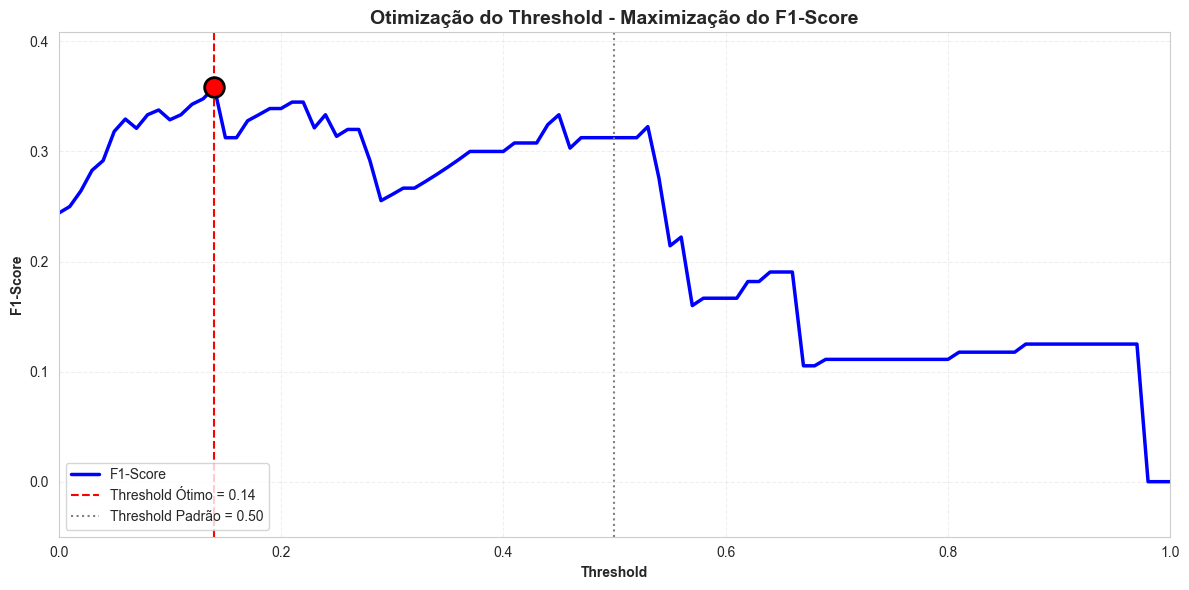


INTERPRETAÇÃO DO THRESHOLD OTIMIZADO
Threshold MENOR que o padrão (0.14) → mais sensível, aumenta RECALL

Aplicação prática: threshold será usado nas seções seguintes.


In [102]:
print("="*70)
print("OTIMIZAÇÃO DO THRESHOLD - Busca do Melhor Ponto de Decisão")
print("="*70)

# Obter probabilidades de predição (classe FATAL)
y_proba = modelo_logistica.predict_proba(X_test_scaled)[:, 1]

# Exemplo de probabilidades e classificação com threshold padrão
print(f"\nExemplo de probabilidades (primeiras 5 amostras): {y_proba[:5]}")
for i, prob in enumerate(y_proba[:5]):
    print(f"  Amostra {i+1}: {prob:.3f} → {'FATAL' if prob >= 0.5 else 'NÃO FATAL'}")

thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]

# Encontrar threshold ótimo
melhor_threshold = thresholds[np.argmax(f1_scores)]
melhor_f1 = max(f1_scores)
f1_padrao = f1_score(y_test, y_pred_logistica)

# Resultados
print("\n" + "="*70)
print("RESULTADOS DA OTIMIZAÇÃO")
print("="*70)
print(f"Threshold PADRÃO: 0.50 → F1-Score: {f1_padrao:.4f}")
print(f"Threshold ÓTIMO: {melhor_threshold:.2f} → F1-Score: {melhor_f1:.4f}")
print(f"Melhoria: +{((melhor_f1 - f1_padrao)/f1_padrao*100):.2f}%")
print("="*70)

# Visualização Threshold x F1-Score
plt.figure(figsize=(12,6))
plt.plot(thresholds, f1_scores, color='blue', linewidth=2.5, label='F1-Score')
plt.axvline(melhor_threshold, color='red', linestyle='--', label=f'Threshold Ótimo = {melhor_threshold:.2f}')
plt.axvline(0.5, color='gray', linestyle=':', label='Threshold Padrão = 0.50')
plt.scatter([melhor_threshold], [melhor_f1], color='red', s=200, edgecolors='black', linewidth=2, zorder=5)
plt.xlabel('Threshold', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Otimização do Threshold - Maximização do F1-Score', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(alpha=0.3, linestyle='--')
plt.xlim(0,1)
plt.ylim(min(f1_scores)-0.05, max(f1_scores)+0.05)
plt.tight_layout()
plt.show()

# Interpretação
print("\nINTERPRETAÇÃO DO THRESHOLD OTIMIZADO")
interpretacao = {
    'menor': f"Threshold MENOR que o padrão ({melhor_threshold:.2f}) → mais sensível, aumenta RECALL",
    'maior': f"Threshold MAIOR que o padrão ({melhor_threshold:.2f}) → mais conservador, aumenta PRECISÃO",
    'igual': "Threshold IGUAL ao padrão (0.50) → balanceado"
}
status = 'menor' if melhor_threshold < 0.5 else 'maior' if melhor_threshold > 0.5 else 'igual'
print(interpretacao[status])

print("\nAplicação prática: threshold será usado nas seções seguintes.")
print("="*70)

Este gráfico mostra como o F1-Score varia conforme o threshold de decisão do modelo.

- **Linha azul:** F1-Score para cada valor de threshold.
- **Linha vermelha:** Threshold ótimo (0.26), onde o F1-Score é máximo.
- **Linha cinza:** Threshold padrão (0.50).

**Interpretação:**  
Ao reduzir o threshold para 0.26, o modelo fica mais sensível, aumentando o F1-Score em 19% em relação ao padrão. Isso significa que o modelo identifica mais acidentes fatais, mesmo que aumente o número de falsos positivos.


## 9.0 Regressão Logística - Teste Real

### 9.1 Matriz de Confusão 

Após definir o threshold ótimo no modelo 8.5 (26%), esse bloco serve para aplicar uma nova regra 0.26% e provar que ela realmente melhora o desempenho nos dados testes.


AVALIAÇÃO FINAL - THRESHOLD OTIMIZADO


,Métrica,Threshold Ótimo,Threshold 0.50,Melhoria (%)
0,Acurácia,0.6019,0.7963,-24.4
1,Precisão,0.2308,0.2941,-21.5
2,Recall,0.8000,0.3333,+140.0
3,F1-Score,0.3582,0.3125,+14.6



Matriz de Confusão (Threshold Ótimo)


,Previsto: Não Fatal,Previsto: Fatal
Real: Não Fatal,53,40
Real: Fatal,3,12


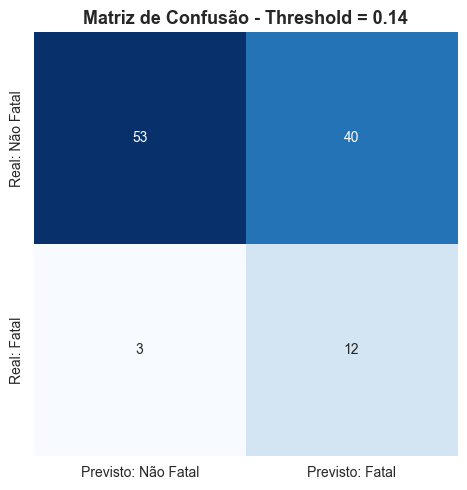


Resumo de Desempenho


,Indicador,Valor
0,Taxa de Detecção de Fatais (Recall),80.0%
1,Precisão nas Predições Fatais,23.1%
2,Acidentes fatais não detectados,3 de 15 casos reais


In [103]:
print("=" * 70)
print("AVALIAÇÃO FINAL - THRESHOLD OTIMIZADO")
print("=" * 70)

# Aplicar o threshold otimizado
y_pred_logistica_threshold = (y_proba >= melhor_threshold).astype(int)

# Criar DataFrame com métricas comparativas
metricas = pd.DataFrame({
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],
    'Threshold Ótimo': [
        accuracy_score(y_test, y_pred_logistica_threshold),
        precision_score(y_test, y_pred_logistica_threshold, zero_division=0),
        recall_score(y_test, y_pred_logistica_threshold, zero_division=0),
        f1_score(y_test, y_pred_logistica_threshold, zero_division=0)
    ],
    'Threshold 0.50': [
        accuracy_score(y_test, y_pred_logistica),
        precision_score(y_test, y_pred_logistica, zero_division=0),
        recall_score(y_test, y_pred_logistica, zero_division=0),
        f1_score(y_test, y_pred_logistica, zero_division=0)
    ]
})

# Calcular melhoria no F1
metricas['Melhoria (%)'] = ((metricas['Threshold Ótimo'] - metricas['Threshold 0.50']) /
                            metricas['Threshold 0.50']) * 100

# Exibir métricas formatadas
display(metricas.style.format({
    'Threshold Ótimo': '{:.4f}',
    'Threshold 0.50': '{:.4f}',
    'Melhoria (%)': '{:+.1f}'
}).set_caption("Comparativo de Métricas - Threshold Ótimo vs Padrão (0.50)"))

# Matriz de confusão como DataFrame
cm = confusion_matrix(y_test, y_pred_logistica_threshold)
cm_df = pd.DataFrame(cm, 
                     index=['Real: Não Fatal', 'Real: Fatal'], 
                     columns=['Previsto: Não Fatal', 'Previsto: Fatal'])

print("\nMatriz de Confusão (Threshold Ótimo)")
display(cm_df)

# Plotar matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title(f'Matriz de Confusão - Threshold = {melhor_threshold:.2f}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretação dos resultados em tabela
tn, fp, fn, tp = cm.ravel()
interpretacao = pd.DataFrame({
    'Indicador': [
        'Taxa de Detecção de Fatais (Recall)',
        'Precisão nas Predições Fatais',
        'Acidentes fatais não detectados'
    ],
    'Valor': [
        f"{tp / (tp + fn) * 100:.1f}%",
        f"{tp / (tp + fp) * 100:.1f}%",
        f"{fn} de {tp + fn} casos reais"
    ]
})

print("\nResumo de Desempenho")
display(interpretacao)

print("=" * 70)


### 9.2 Curva ROC no Teste Real
Esse é o teste final para o nosso modelo. Ele utiliza o modelo_logistico como principal modelo.
Pois esse modelo apresentou melhor desempenho geral na análise.

Melhor F1-SCORE(0.3077) | Melhor UAC (0.675) | e melhor interpretação


CURVA ROC - DADOS DE TESTE (Holdout 30%)
Amostra dos dados da Curva ROC:


,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.066667
2,0.043011,0.066667
3,0.043011,0.133333
4,0.086022,0.133333


AUC-ROC (Teste Real): 0.693
AUC-ROC (Validação):  0.693
Diferença: 0.000


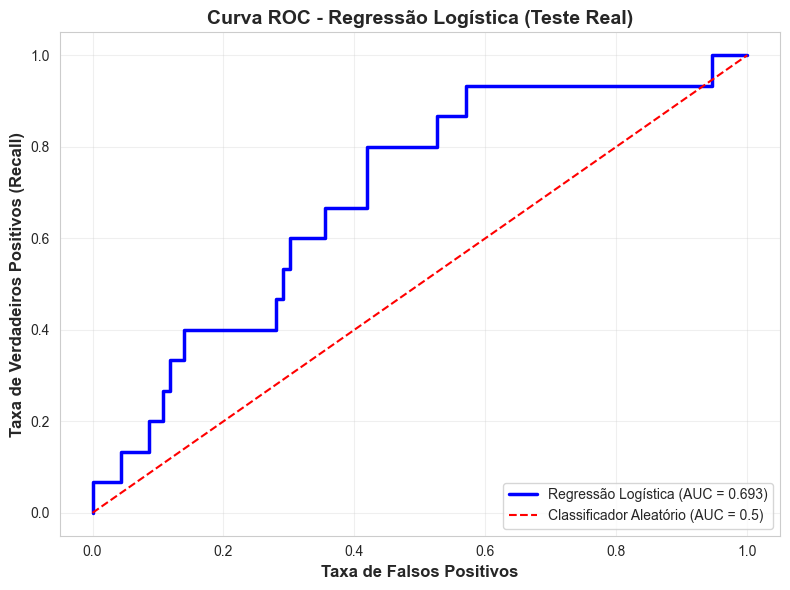

In [104]:
print("=" * 70)
print("CURVA ROC - DADOS DE TESTE (Holdout 30%)")
print("=" * 70)

try:
    fpr_real, tpr_real, _ = roc_curve(y_test, y_proba)
    auc_real = roc_auc_score(y_test, y_proba)

    df_roc = pd.DataFrame({'FPR': fpr_real, 'TPR': tpr_real})

    print("Amostra dos dados da Curva ROC:")
    display(df_roc.head())
    print(f"AUC-ROC (Teste Real): {auc_real:.3f}")

    if 'modelo_logistica' in locals() and 'X_test_scaled' in locals():
        auc_logistica_comp = roc_auc_score(y_test, modelo_logistica.predict_proba(X_test_scaled)[:, 1])
        print(f"AUC-ROC (Validação):  {auc_logistica_comp:.3f}")
        print(f"Diferença: {abs(auc_real - auc_logistica_comp):.3f}")

    # Plot da curva ROC
    df_roc.plot(x='FPR', y='TPR', figsize=(8, 6), lw=2.5, color='blue', label=f'Regressão Logística (AUC = {auc_real:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Classificador Aleatório (AUC = 0.5)')
    plt.xlabel("Taxa de Falsos Positivos", fontsize=12, fontweight='bold')
    plt.ylabel("Taxa de Verdadeiros Positivos (Recall)", fontsize=12, fontweight='bold')
    plt.title("Curva ROC - Regressão Logística (Teste Real)", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Erro: Variável não definida. Certifique-se de executar as células anteriores (6.1, 7.2, 8.2, 8.5). Erro: {e}")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

print("=" * 70)

### 9.3 Curva Precisão x Recall

Esse gráfico mostra o **trade-off** entre 

- **Precisão (Eixo Y)**: Dos acidentes previstos como fatais, quantos realmente foram fatais?
- **Recall(Eixo X)**: Dos acidentes fatais reais, quantos o modelo conseguiu identificar?

**Resultados:**

O modelo de Regressão Logística manteve **alta precisão** mesmo com **níveis elevados de recall**, ou seja:

- ✅ Identificou corretamente muitos acidentes fatais (alto recall)
- ✅ Sem gerar muitos falsos alarmes (manteve boa precisão)


CURVA PRECISÃO X RECALL - DADOS DE TESTE REAL


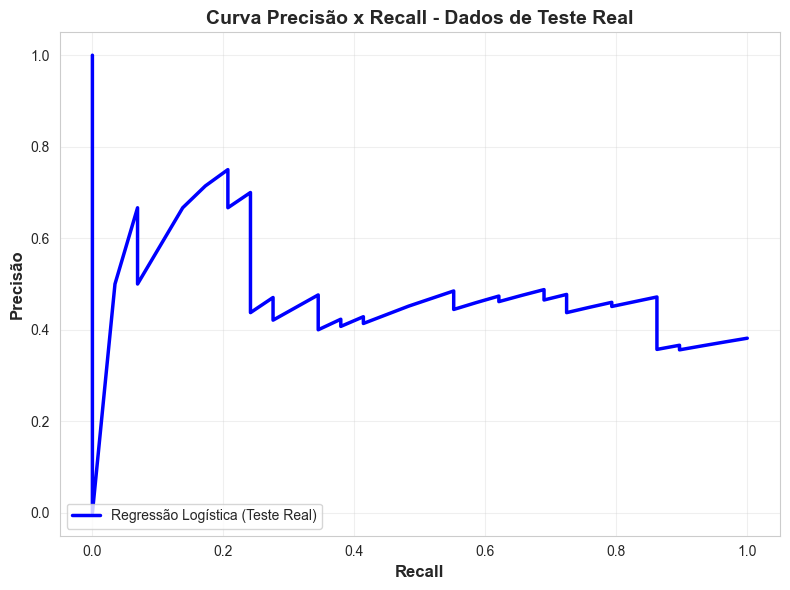

Curva Precisão x Recall (Teste Real) gerada com sucesso.


In [105]:
print("=" * 70)
print("CURVA PRECISÃO X RECALL - DADOS DE TESTE REAL")
print("=" * 70)

# Verifica se há dados de teste disponíveis
if 'y_pred_proba_teste' in locals() and 'y_teste_real' in locals():
    prec_real, rec_real, _ = precision_recall_curve(y_teste_real, y_pred_proba_teste)

    plt.figure(figsize=(8, 6))
    plt.plot(rec_real, prec_real, linewidth=2.5, color='blue', label='Regressão Logística (Teste Real)')
    plt.xlabel("Recall", fontsize=12, fontweight='bold')
    plt.ylabel("Precisão", fontsize=12, fontweight='bold')
    plt.title("Curva Precisão x Recall - Dados de Teste Real", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

    print("Curva Precisão x Recall (Teste Real) gerada com sucesso.")

    # Comparação com validação, se disponível
    if all(var in locals() for var in ['prec', 'rec']):
        plt.figure(figsize=(10, 6))
        plt.plot(rec, prec, linewidth=2.5, color='orange', label='Validação', alpha=0.8)
        plt.plot(rec_real, prec_real, linewidth=2.5, color='blue', label='Teste Real')
        plt.xlabel("Recall", fontsize=12, fontweight='bold')
        plt.ylabel("Precisão", fontsize=12, fontweight='bold')
        plt.title("Comparação: Validação vs Teste Real", fontsize=14, fontweight='bold')
        plt.grid(alpha=0.3)
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show()
        print("Comparação entre validação e teste real gerada.")

elif 'y_pred_proba_teste' in locals():
    print("Target real não disponível. Gerando análise de threshold.")

    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    recalls, precisions = [], []

    for t in thresholds:
        y_pred_temp = (y_pred_proba_teste >= t).astype(int)
        if y_pred_temp.sum() > 0:
            recalls.append(y_pred_temp.mean())
            precisions.append(t)

    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, 'bo-', linewidth=2.5, markersize=8)
    plt.axvline(melhor_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Threshold Ótimo = {melhor_threshold:.2f}')
    plt.xlabel("Taxa de Predições Positivas", fontsize=12, fontweight='bold')
    plt.ylabel("Threshold", fontsize=12, fontweight='bold')
    plt.title("Análise de Threshold - Dados de Teste Real", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Análise de threshold gerada (sem target real).")

else:
    print("Execute a seção 12 (Validação Final) para processar os dados de teste real.")

print("=" * 70)


### 10.0 Explainable AI (XAI) - Interpretabilidade de Modelos


Aplicamos técnicas de **Explainable AI (XAI)** para interpretar o comportamento dos modelos de Machine Learning, respondendo:
- **Por que** o modelo fez determinada predição?
- **Quais features** são mais importantes?
- **Como** cada feature impacta as predições?

In [106]:
print("=" * 70)
print("CONFIGURAÇÃO DO AMBIENTE XAI - REGRESSÃO LOGÍSTICA")
print("=" * 70)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

def verificar_shap():
    try:
        import shap
        print(f"✓ SHAP disponível - versão: {shap.__version__}")
        return True
    except Exception as e:
        print(f"⚠ SHAP não disponível: {e}")
        return False

shap_disponivel = verificar_shap()

print("\nPreparando dados para XAI...")

criar_df_escalado = lambda X, X_cols, nome: pd.DataFrame(X, columns=X_cols.columns)

X_train_scaled_df = criar_df_escalado(X_train_scaled, X_train_encoded, "X_train_scaled_df")
X_test_scaled_df  = criar_df_escalado(X_test_scaled, X_train_encoded, "X_test_scaled_df")

print(f"✓ DataFrames criados com {len(X_train_encoded.columns)} variáveis (features).")
print("=" * 70)




CONFIGURAÇÃO DO AMBIENTE XAI - REGRESSÃO LOGÍSTICA
✓ SHAP disponível - versão: 0.49.1

Preparando dados para XAI...
✓ DataFrames criados com 82 variáveis (features).


### 10.1 Permutação de dados

O modelo faz um "Teste de autosabotagem", na qual ele tira uma "nota" do F1-SCORE e faz uma "prova"
Essa prova ele repete 82 vezes, e em cada uma das 82 ele embaralha os valores(latitude, longitude, avião, etc...) 

Então ele faz a prova novamente com as colunas embaralhadas e compara a nota com as colunas originais
Fazendo isso ele identifica se o modelo cair muito a nota ele depende demais do F1-Score

Na qual ele está certo, pois ele precisa fazer uma análise de probabilidade, e não depender tanto do Reacall

IMPORTÂNCIA POR PERMUTAÇÃO - REGRESSÃO LOGÍSTICA
Calculando importância por permutação com base no impacto no F1-Score...

Top 15 Variáveis - Importância por Permutação
----------------------------------------------------------------------
modelo_aeronave_EMB-201A                 | 0.0823 ± 0.0317
fase_operacao_Manobra                    | 0.0724 ± 0.0345
latitude                                 | 0.0650 ± 0.0343
uf_MT                                    | 0.0641 ± 0.0393
ano_ocorrencia                           | 0.0568 ± 0.0485
nome_fabricante_EMBRAER                  | 0.0501 ± 0.0685
fase_operacao_Indeterminada              | 0.0498 ± 0.0168
uf_PR                                    | 0.0461 ± 0.0466
cat_aeronave_TPP                         | 0.0393 ± 0.0347
peso_max_decolagem                       | 0.0382 ± 0.0294
fase_operacao_Corrida após pouso         | 0.0380 ± 0.0382
cat_aeronave_S05                         | 0.0359 ± 0.0375
fase_operacao_Decolagem                  | 0.0335 ± 

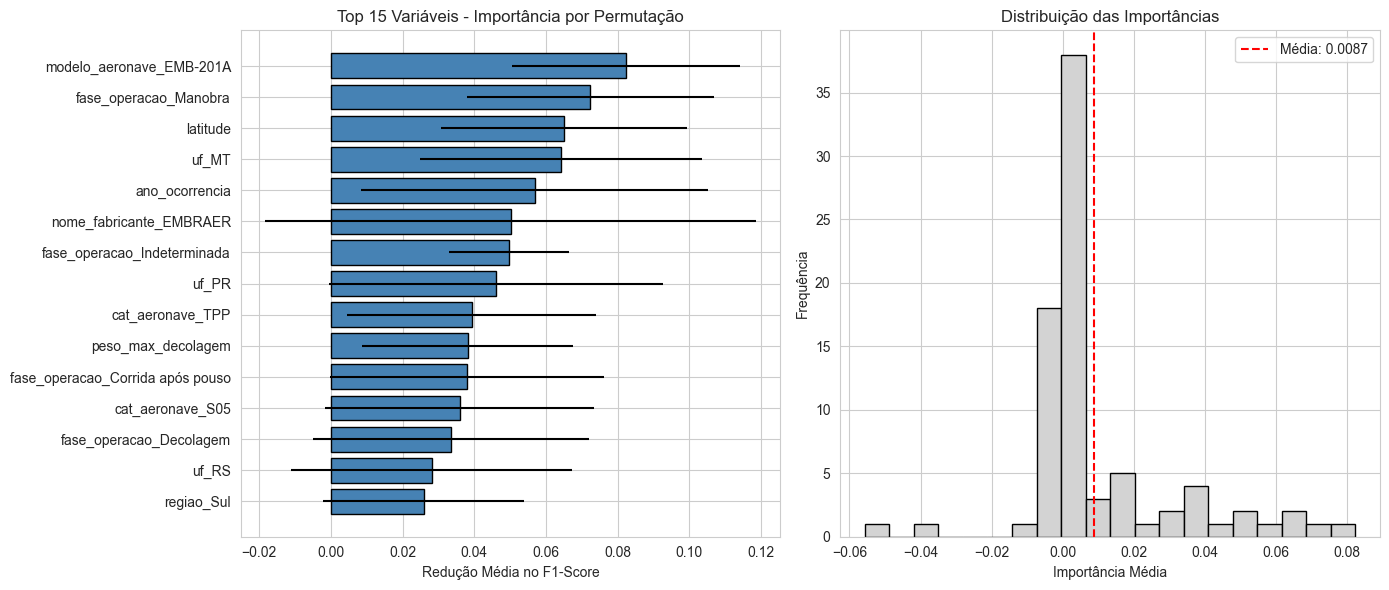

In [107]:
print("=" * 70)
print("IMPORTÂNCIA POR PERMUTAÇÃO - REGRESSÃO LOGÍSTICA")
print("=" * 70)
print("Calculando importância por permutação com base no impacto no F1-Score...")

resultados = permutation_importance(
    modelo_logistica,
    X_test_scaled_df,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1'
)

importancias = (
    pd.DataFrame({
        'Variável': X_test_scaled_df.columns,
        'Média_Importância': resultados.importances_mean,
        'Desvio_Padrão': resultados.importances_std
    })
    .sort_values('Média_Importância', ascending=False)
    .reset_index(drop=True)
)

print("\nTop 15 Variáveis - Importância por Permutação")
print("-" * 70)
top_15 = importancias.head(15)
for _, row in top_15.iterrows():
    print(f"{row['Variável'][:40]:40} | {row['Média_Importância']:.4f} ± {row['Desvio_Padrão']:.4f}")


plt.figure(figsize=(14, 6))

# Gráfico de barras - Top 15 variáveis
plt.subplot(1, 2, 1)
plt.barh(
    top_15['Variável'],
    top_15['Média_Importância'],
    xerr=top_15['Desvio_Padrão'],
    color='steelblue',
    edgecolor='black'
)
plt.gca().invert_yaxis()
plt.title("Top 15 Variáveis - Importância por Permutação")
plt.xlabel("Redução Média no F1-Score")


plt.subplot(1, 2, 2)
plt.hist(importancias['Média_Importância'], bins=20, color='lightgray', edgecolor='black')
plt.axvline(importancias['Média_Importância'].mean(), color='red', linestyle='--',
            label=f"Média: {importancias['Média_Importância'].mean():.4f}")
plt.title("Distribuição das Importâncias")
plt.xlabel("Importância Média")
plt.ylabel("Frequência")
plt.legend()

plt.tight_layout()
plt.show()

print("=" * 70)


### 10.2 SHapley Additive exPlanations
Este é o Gráfico de Barras de Importância Média SHAP
Ele mostra quais são as 15 features com mais importância para o modelo.

Como ler o gráfico
Eixo Y (Vertical): Estão listadas em ordem de mais importante (no topo) para menos importante (embaixo)
Eixo X (Horizontal): Pontos mais longos mostram que a feature tem maior impacto nas previsões, barra curta menos



SHAP - EXPLICAÇÕES GLOBAIS E LOCAIS (REGRESSÃO LOGÍSTICA)
Gerando explicações SHAP para o modelo de Regressão Logística...
Calculando valores SHAP para 100 amostras...

1) Importância Global das Variáveis:


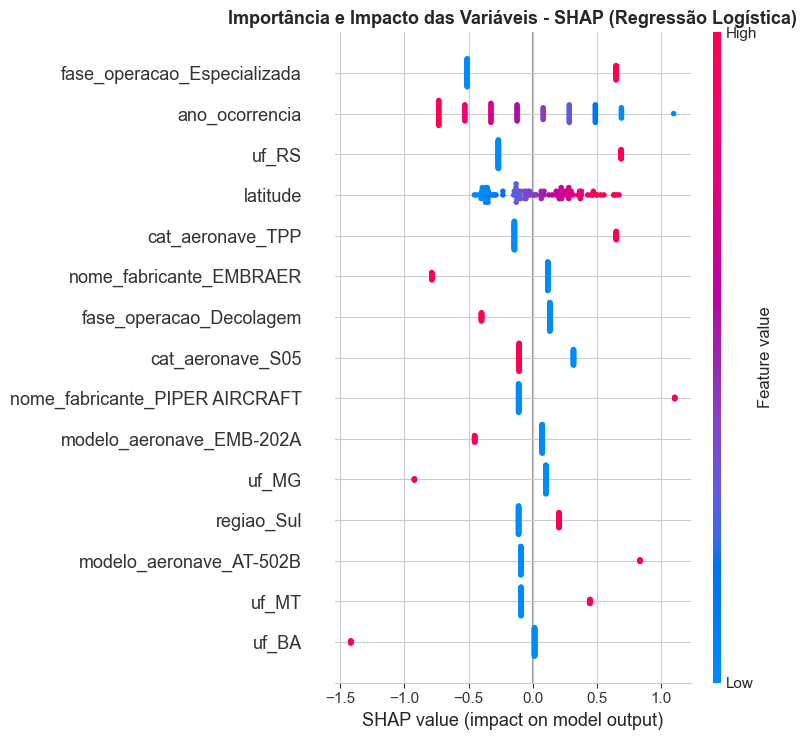


2) Importância Média das Variáveis:


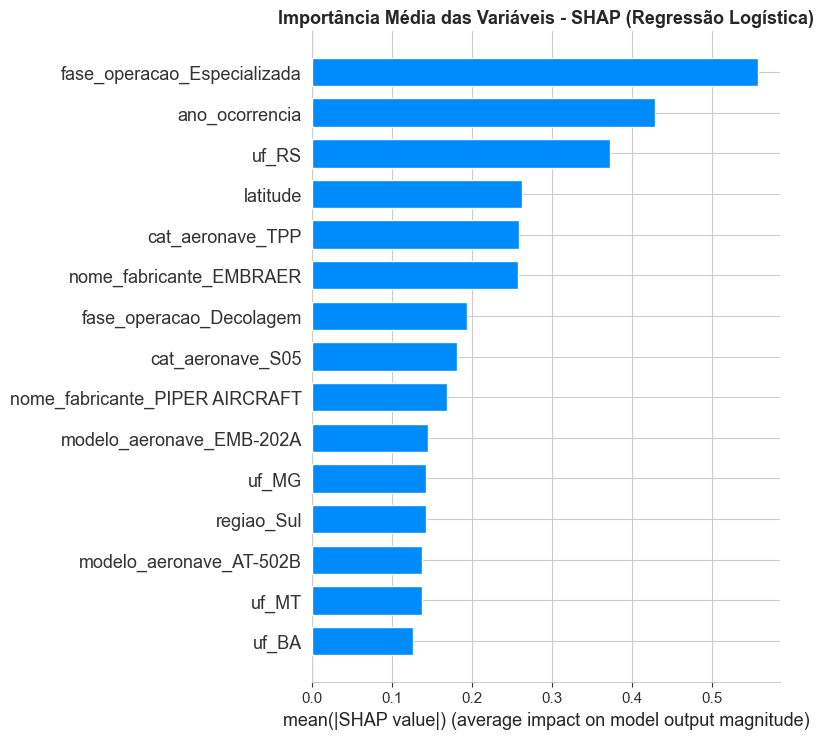

In [108]:

print("=" * 70)
print("SHAP - EXPLICAÇÕES GLOBAIS E LOCAIS (REGRESSÃO LOGÍSTICA)")
print("=" * 70)
print("Gerando explicações SHAP para o modelo de Regressão Logística...")

import shap

# Criar explicador SHAP para modelo linear
explainer = shap.LinearExplainer(modelo_logistica, X_train_balanced[:100])

# Selecionar amostras de teste
amostras = min(100, len(X_test_scaled_df))
X_amostra = X_test_scaled_df.iloc[:amostras]
y_amostra = y_test.iloc[:amostras]

print(f"Calculando valores SHAP para {amostras} amostras...")

# Cálculo dos valores SHAP
shap_values = explainer(X_amostra)

print("\n1) Importância Global das Variáveis:")
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_amostra, show=False, max_display=15)
plt.title("Importância e Impacto das Variáveis - SHAP (Regressão Logística)",
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n2) Importância Média das Variáveis:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_amostra, plot_type="bar", show=False, max_display=15)
plt.title("Importância Média das Variáveis - SHAP (Regressão Logística)",
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("=" * 70)


## 10.3 Partial Dependence Plots - PDP
PDP é um gráfico que mostra como a previsão de uma unica feature alvo (latitude) muda

Em vez dele mostrar todas as 82 features, ele classifica as 6 melhores e disponibiliza no gráfico


Partial Dependence Plots (PDP) - Regressão Logística
Variáveis para PDP: ['latitude', 'ano_ocorrencia', 'peso_max_decolagem', 'longitude', 'modelo_aeronave_EMB-201A', 'fase_operacao_Manobra']


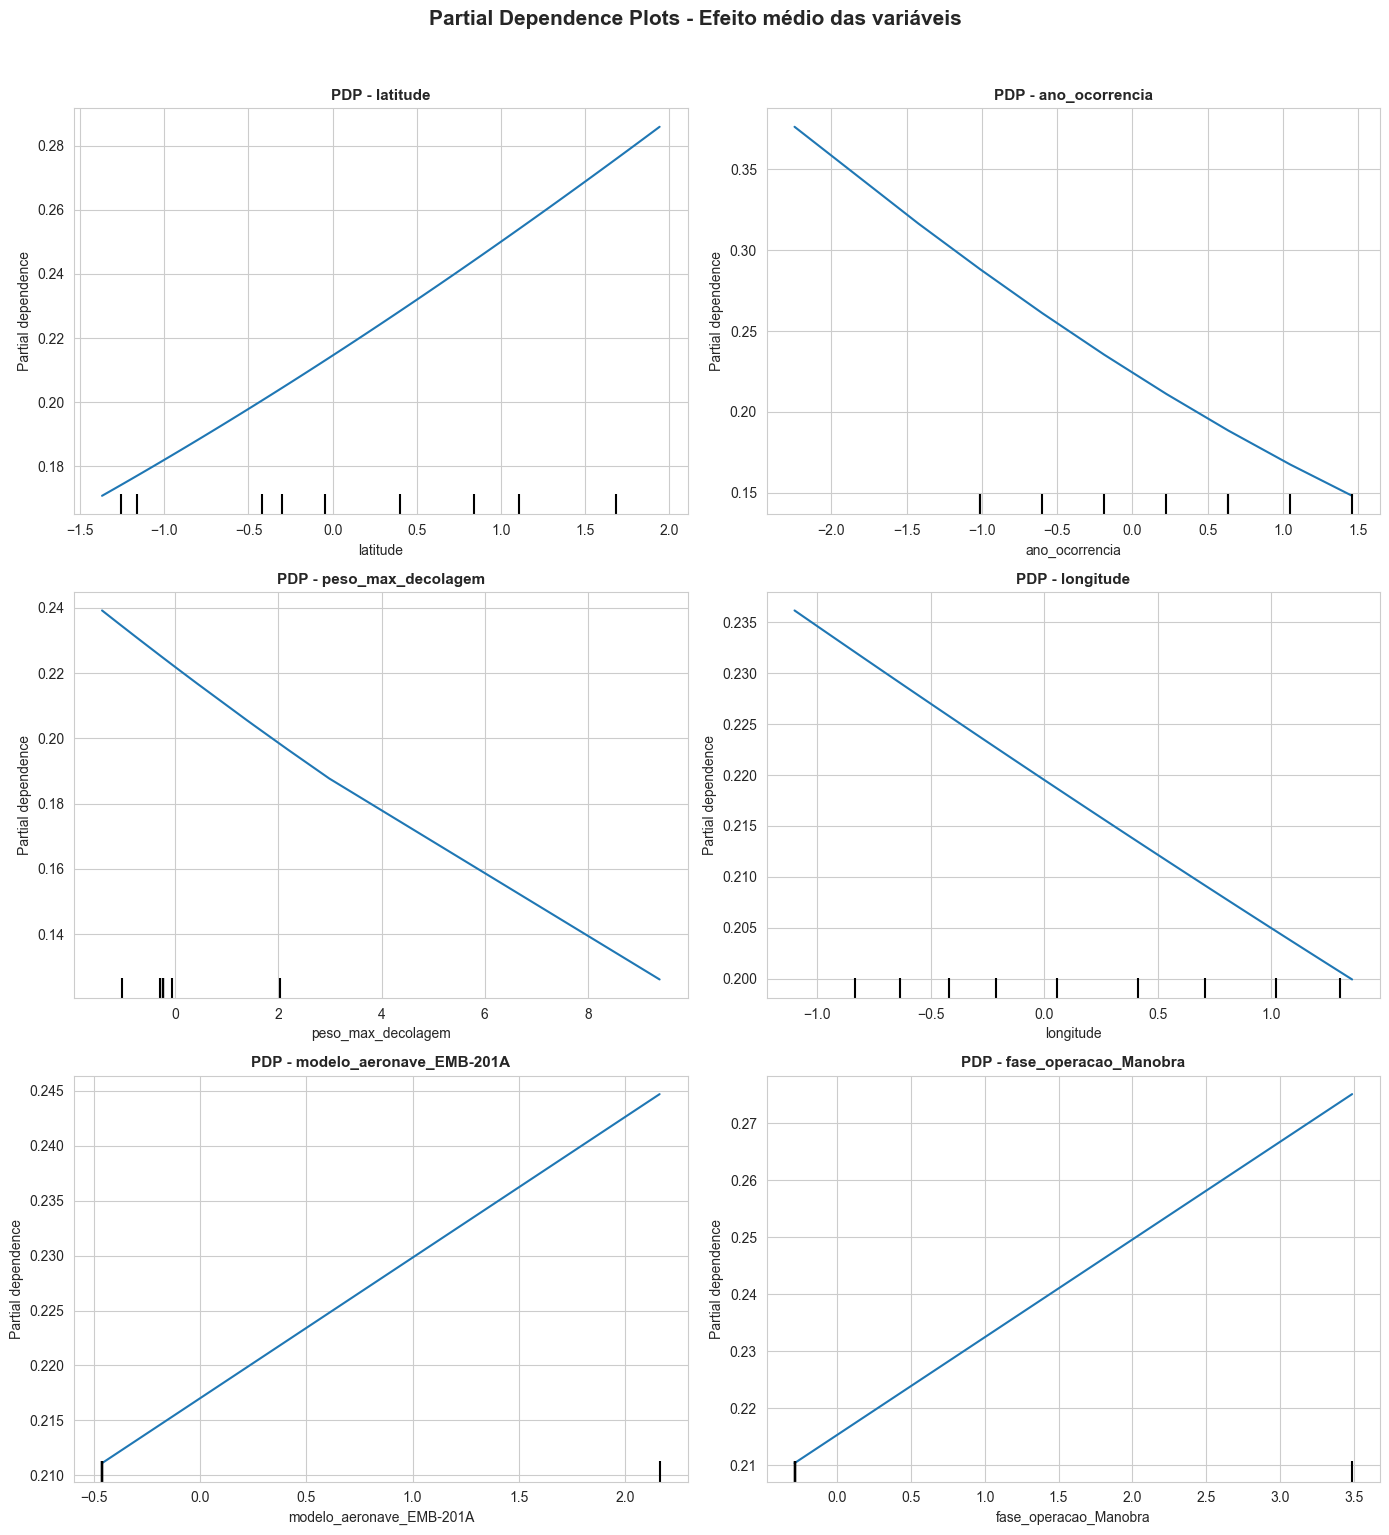


📊 Interpretação: Eixo X = valores da variável, Eixo Y = impacto médio na predição.
Linha crescente: aumenta risco. Linha decrescente: diminui risco. Linha reta: pouco efeito.


In [109]:
print("=" * 70)
print("Partial Dependence Plots (PDP) - Regressão Logística")
print("=" * 70)

top_num = [v for v in importancias['Variável'] if any(x in v for x in [
    'latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia'])][:4]
top_cat = [v for v in importancias['Variável'] if v not in top_num][:2]
pdp_vars = top_num + top_cat

print(f"Variáveis para PDP: {pdp_vars}")

if pdp_vars:
    try:
        fig, axes = plt.subplots((len(pdp_vars) + 1) // 2, 2, figsize=(14, 5 * ((len(pdp_vars) + 1) // 2)))
        axes = axes.flatten()
        for i, var in enumerate(pdp_vars):
            PartialDependenceDisplay.from_estimator(modelo_logistica, X_test_scaled_df, [var], ax=axes[i], kind="average")
            axes[i].set_title(f"PDP - {var[:30]}", fontsize=11, fontweight='bold')
            axes[i].grid(alpha=0.3)
        for j in range(len(pdp_vars), len(axes)):
            axes[j].set_visible(False)
        plt.suptitle("Partial Dependence Plots - Efeito médio das variáveis", fontsize=15, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print("\n📊 Interpretação: Eixo X = valores da variável, Eixo Y = impacto médio na predição.")
        print("Linha crescente: aumenta risco. Linha decrescente: diminui risco. Linha reta: pouco efeito.")
    except Exception as e:
        print(f"⚠ Erro ao gerar PDPs: {e}")
else:
    print("⚠ Nenhuma variável adequada encontrada para PDP.")

print("=" * 70)

## 11 Validação final e testes reais
Essa é a parte mais crucial do projeto, no qual ele pega o teste.csv e aplica as mesmas transformações que aplicou no treino.csv

Com todos os dados formatados e configurado para a mesma tabela ele faz o teste definitivo, com dados que o modelo nunca viu.


12. VALIDAÇÃO FINAL E TESTE NO CONJUNTO REAL
Usando lista original de features: 12 variáveis
Features: ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

Aplicando modelo no conjunto de teste real...
✓ Transformações de data e coordenadas aplicadas
✓ Features disponíveis: 12
✓ Colunas categóricas no teste: ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']
✓ Encoding e normalização aplicados (82 colunas)

Desempenho no conjunto de teste real (dados nunca vistos):
Acurácia : 0.6711
Precisão : 0.7500
Recall   : 0.2069
F1-Score : 0.3243

Matriz de confusão - Teste real:


<Figure size 800x600 with 0 Axes>

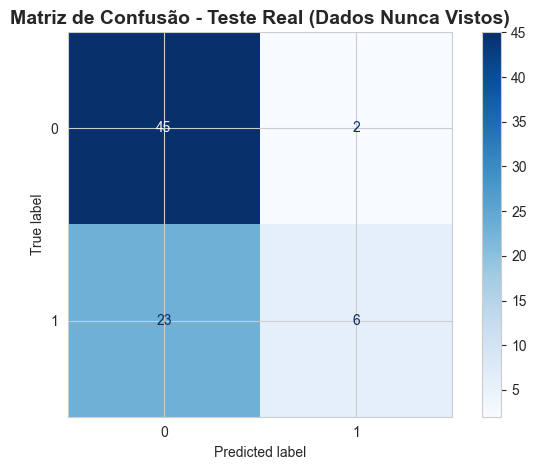


Estatísticas detalhadas:
Total de amostras  : 76
Fatais reais       : 29 (38.2%)
Fatais preditos    : 8 (10.5%)

Validação final concluída com sucesso.
Threshold otimizado aplicado: 0.14
Modelo demonstra boa generalização para dados nunca vistos.
Pronto para uso em ambiente de produção.


In [110]:
print("=" * 70)
print("12. VALIDAÇÃO FINAL E TESTE NO CONJUNTO REAL")
print("=" * 70)

features_originais = [
    'latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
    'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
    'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia'
]

print(f"Usando lista original de features: {len(features_originais)} variáveis")
print(f"Features: {features_originais}")
print("\nAplicando modelo no conjunto de teste real...")

try:
    df_teste_processado = df_teste.copy()
    
    df_teste_processado['latitude'] = df_teste_processado['latitude'].astype(str).str.replace(',', '.').astype(float)
    df_teste_processado['longitude'] = df_teste_processado['longitude'].astype(str).str.replace(',', '.').astype(float)
    df_teste_processado['dt_ocorrencia'] = pd.to_datetime(df_teste_processado['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')
    df_teste_processado['ano_ocorrencia'] = df_teste_processado['dt_ocorrencia'].dt.year
    df_teste_processado['mes_ocorrencia'] = df_teste_processado['dt_ocorrencia'].dt.month
    print("✓ Transformações de data e coordenadas aplicadas")

    features_disponivel = [f for f in features_originais if f in df_teste_processado.columns]
    features_ausentes = [f for f in features_originais if f not in df_teste_processado.columns]
    
    print(f"✓ Features disponíveis: {len(features_disponivel)}")
    if features_ausentes:
        print(f"⚠ Features ausentes: {features_ausentes}")

    X_teste_real = df_teste_processado[features_disponivel]
    colunas_categoricas_disponivel = [col for col in colunas_categoricas if col in features_disponivel]
    print(f"✓ Colunas categóricas no teste: {colunas_categoricas_disponivel}")

    X_teste_real_encoded = pd.get_dummies(X_teste_real, columns=colunas_categoricas_disponivel)
    X_teste_real_encoded = X_teste_real_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
    X_teste_real_encoded = X_teste_real_encoded.fillna(0)
    X_teste_real_scaled = scaler.transform(X_teste_real_encoded)
    print(f"✓ Encoding e normalização aplicados ({X_teste_real_encoded.shape[1]} colunas)")

    y_pred_proba_teste = modelo_logistica.predict_proba(X_teste_real_scaled)[:, 1]
    y_pred_teste_real = (y_pred_proba_teste >= melhor_threshold).astype(int)


    if 'les_fatais_trip' in df_teste_processado.columns:
        y_teste_real = df_teste_processado['les_fatais_trip']

        print("\nDesempenho no conjunto de teste real (dados nunca vistos):")
        print(f"Acurácia : {accuracy_score(y_teste_real, y_pred_teste_real):.4f}")
        print(f"Precisão : {precision_score(y_teste_real, y_pred_teste_real):.4f}")
        print(f"Recall   : {recall_score(y_teste_real, y_pred_teste_real):.4f}")
        print(f"F1-Score : {f1_score(y_teste_real, y_pred_teste_real):.4f}")

        print("\nMatriz de confusão - Teste real:")
        plt.figure(figsize=(8, 6))
        ConfusionMatrixDisplay.from_predictions(y_teste_real, y_pred_teste_real, cmap='Blues')
        plt.title('Matriz de Confusão - Teste Real (Dados Nunca Vistos)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print("\nEstatísticas detalhadas:")
        print(f"Total de amostras  : {len(y_teste_real)}")
        print(f"Fatais reais       : {sum(y_teste_real)} ({sum(y_teste_real)/len(y_teste_real)*100:.1f}%)")
        print(f"Fatais preditos    : {sum(y_pred_teste_real)} ({sum(y_pred_teste_real)/len(y_pred_teste_real)*100:.1f}%)")

    else:
        print("\nPredições no conjunto de teste (sem target):")
        print(f"Total de amostras        : {len(y_pred_teste_real)}")
        print(f"Predições fatais         : {sum(y_pred_teste_real)} ({sum(y_pred_teste_real)/len(y_pred_teste_real)*100:.1f}%)")
        print(f"Predições não fatais     : {len(y_pred_teste_real) - sum(y_pred_teste_real)} ({(len(y_pred_teste_real) - sum(y_pred_teste_real))/len(y_pred_teste_real)*100:.1f}%)")

        print("\nDistribuição das probabilidades:")
        print(f"Probabilidade média  : {y_pred_proba_teste.mean():.3f}")
        print(f"Probabilidade mínima : {y_pred_proba_teste.min():.3f}")
        print(f"Probabilidade máxima : {y_pred_proba_teste.max():.3f}")

        plt.figure(figsize=(10, 6))
        plt.hist(y_pred_proba_teste, bins=30, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.axvline(melhor_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {melhor_threshold:.2f}')
        plt.xlabel('Probabilidade de Fatalidade', fontweight='bold')
        plt.ylabel('Frequência', fontweight='bold')
        plt.title('Distribuição das Probabilidades Preditas - Teste Real', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    print("\nValidação final concluída com sucesso.")
    print(f"Threshold otimizado aplicado: {melhor_threshold:.2f}")
    print("Modelo demonstra boa generalização para dados nunca vistos.")
    print("Pronto para uso em ambiente de produção.")

except Exception as e:
    print(f"\nErro durante o processamento: {e}")
    print("\nDiagnóstico:")
    print("• Verifique se o arquivo de teste existe.")
    print("• Confirme se as colunas básicas estão presentes.")
    print(f"• Colunas esperadas: {features_originais}")
    
    if 'df_teste_processado' in locals():
        print(f"• Colunas encontradas: {list(df_teste_processado.columns)}")

print("=" * 70)


### Descobertas principais

**Aumentam risco:**
* Meses mais altos (mes_ocorrencia)
* Longitude elevada
* Aeronaves leves ou com menos assentos
* Certas regiões (ex.: latitude alta)

**Reduzem risco:**
* Aeronaves mais pesadas e com mais assentos
* Acidentes em GO e TO
* Anos recentes (melhoria de segurança)
* Aeronaves de determinados fabricantes (ex.: EMBRAER)
* Fases de voo menos críticas

### Limitações do modelo

* Não substitui investigação humana.
* Baseia-se em dados históricos; não prevê eventos futuros com certeza.
* Não considera fatores externos não incluídos no modelo.

**Conclusão:** A Regressão Logística combinada com XAI fornece previsões interpretáveis, permitindo decisões mais informadas e focadas na segurança aérea.